## Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Conv1D, MaxPooling1D, Flatten, Concatenate, Dense, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')


## Data

In [8]:
df_train = pd.read_csv('data/train.csv')

df_train.sample(10)

,date,store,item,sales
310656,2013-08-25,1,18,97
813859,2016-07-13,6,45,101
650264,2013-07-28,7,36,71
228963,2014-12-15,6,13,38
258616,2016-02-25,2,15,82
188882,2015-03-16,4,11,53
317484,2017-05-06,4,18,134
169454,2017-01-02,3,10,57
161198,2014-05-26,9,9,36
342574,2016-01-18,8,19,45


In [9]:
df_test = pd.read_csv('data/test.csv')

df_test = df_test.drop(columns=['id'], axis=1)

df_test.head()

,date,store,item
0,2018-01-01,1,1
1,2018-01-02,1,1
2,2018-01-03,1,1
3,2018-01-04,1,1
4,2018-01-05,1,1


## Data Cleaning

In [10]:
# Null values
df_train.isnull().value_counts()

date   store  item   sales
False  False  False  False    913000
Name: count, dtype: int64

In [11]:
# NA values
df_train.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [12]:
# Duplicates
df_train.duplicated().sum()

0

In [13]:
df_train.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

Since date column is object - convert it to date format

In [14]:
df_train['date'] = pd.to_datetime(df_train['date'], format="%Y-%m-%d")

df_train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [15]:
df_train.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

Make sure the data is sorted as per date

In [16]:
df_train = df_train.sort_values(by=['date', 'store', 'item']).reset_index(drop=True)

df_train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-01,1,2,33
2,2013-01-01,1,3,15
3,2013-01-01,1,4,10
4,2013-01-01,1,5,11


## EDA

<Axes: xlabel='date', ylabel='sales'>

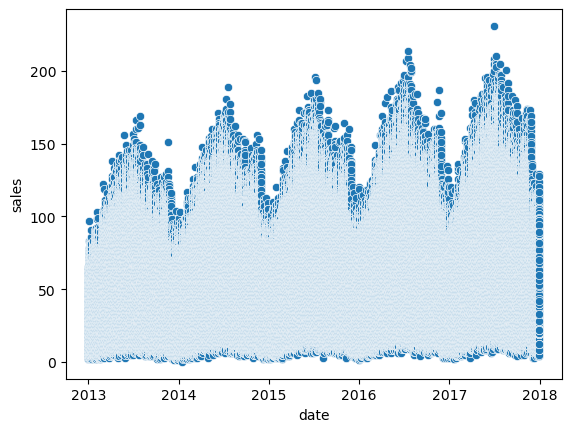

In [17]:
sns.scatterplot(data=df_train, x='date', y='sales')

Sales increases per year - positive trend

<Axes: xlabel='store', ylabel='sales'>

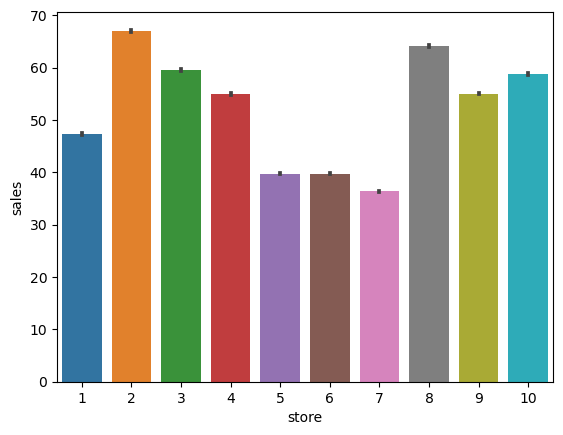

In [18]:
sns.barplot(data=df_train, x='store', y='sales')

<Axes: xlabel='item', ylabel='sales'>

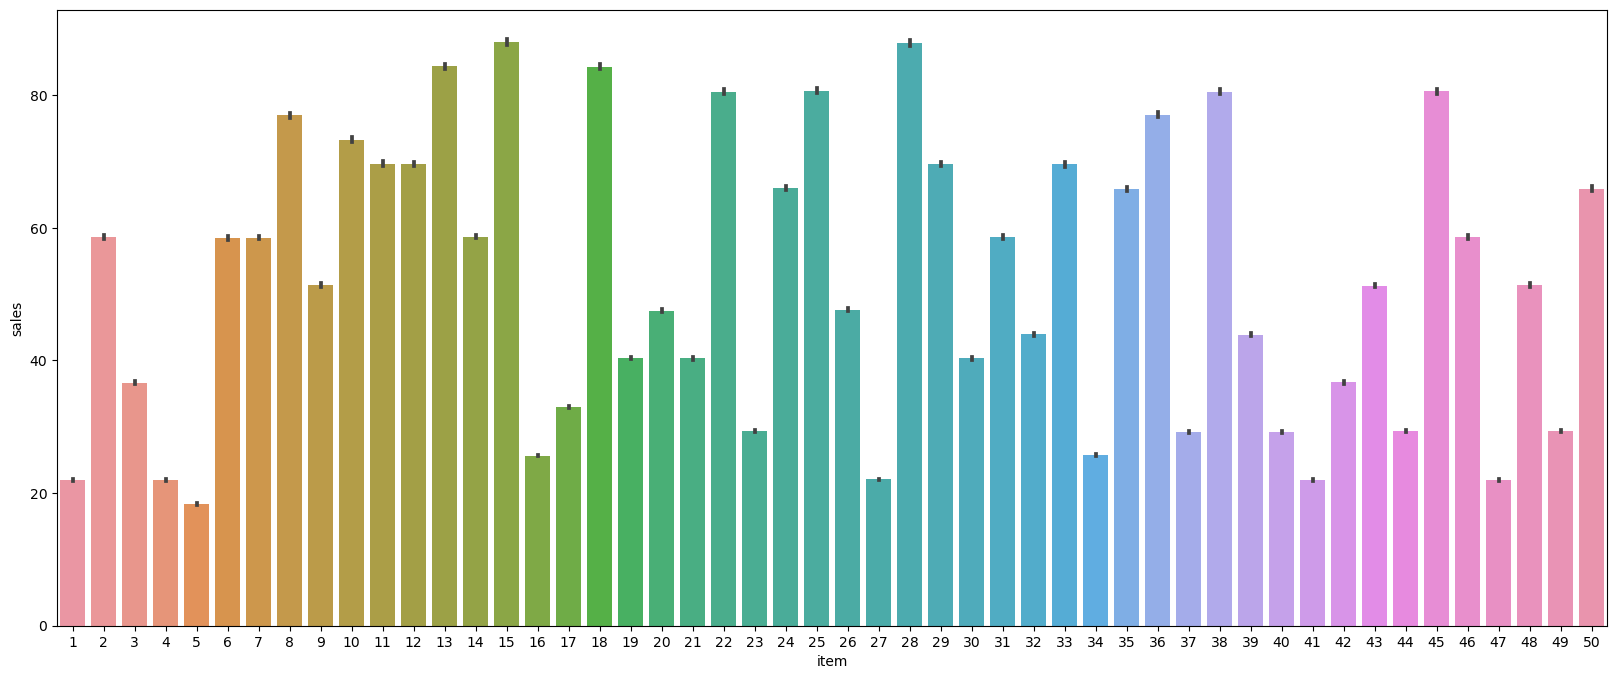

In [19]:
fig = plt.figure(figsize=(20,8))
sns.barplot(data=df_train, x='item', y='sales')

Each store has different demand and each item has a different demand - so each store item pair will have a different demand

In [20]:
pivoted_sales = df_train.pivot_table(index='date', columns=['store', 'item'], values='sales', aggfunc='sum')

pivoted_sales.head()

store       1                                       ...  10                  \
item        1   2   3   4   5   6   7   8   9   10  ...  41  42  43  44  45   
date                                                ...                       
2013-01-01  13  33  15  10  11  31  25  33  18  37  ...  12  20  24  17  45   
2013-01-02  11  43  30  11   6  36  23  37  23  34  ...  10  22  29  10  45   
2013-01-03  14  23  14   8   8  18  34  38  25  32  ...  17  27  43  20  56   
2013-01-04  13  18  10  19   9  19  36  54  22  45  ...  13  24  27  12  50   
2013-01-05  10  34  23  12   8  31  38  51  29  35  ...  14  25  31  25  62   

store                           
item        46  47  48  49  50  
date                            
2013-01-01  37  11  25  17  33  
2013-01-02  33  13  24  13  37  
2013-01-03  28  16  29  19  46  
2013-01-04  44  11  39  23  51  
2013-01-05  45  16  34  22  41  

[5 rows x 500 columns]

## ML Models

### Random Forest

In [ ]:
X_rf = df_train.copy()

In [ ]:
y_rf = X_rf['sales']


Reshaping not required for RF. Convert date to ordinal as RF doesn't understand date type - Add date related features as date is not significant when it comes to regression models

In [ ]:
X_rf['dow'] = X_rf['date'].dt.dayofweek
X_rf['month'] = X_rf['date'].dt.month
X_rf['year'] = X_rf['date'].dt.year


# Converting 'date' column to ordinal to use it as a feature
X_rf['date'] = X_rf['date'].apply(lambda x: x.toordinal())

X_rf.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dow               int32
day               int32
month             int32
year              int32
dtype: object

In [ ]:
# Dropping the 'sales' column from features
X_rf = X_rf.drop(columns=['sales'])

In [ ]:
# Splitting the data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

In [ ]:
#Model
rf_model = RandomForestRegressor(n_estimators=100,
                                 max_depth=10,
                                 min_samples_split=2,
                                 min_samples_leaf=1)

In [ ]:
#RF Modeling fitting
rf_model.fit(X_train_rf,y_train_rf)

RandomForestRegressor(max_depth=10)

In [ ]:
#predicting on training set
y_train_pred_rf = rf_model.predict(X_train_rf)

# Calculating Mean Squared Error on training set
mse_rf_train = mean_squared_error(y_train_rf, y_train_pred_rf)
print("Mean Squared Error on Training Set:", mse_rf_train)

Mean Squared Error on Training Set: 358.8411262099781


In [ ]:
#predicting on testing set
y_test_pred_rf = rf_model.predict(X_test_rf)

# Calculating Mean Squared Error on testing set
mse_rf_test = mean_squared_error(y_test_rf, y_test_pred_rf)
print("Mean Squared Error on Testing Set:", mse_rf_test)

Mean Squared Error on Testing Set: 357.40317904439235


### XGBoost

In [ ]:
X_xgb = df_train.copy()

In [ ]:
y_xgb = X_xgb['sales']

In [ ]:
X_xgb['dow'] = X_xgb['date'].dt.dayofweek
X_xgb['day'] = X_xgb['date'].dt.day
X_xgb['month'] = X_xgb['date'].dt.month
X_xgb['year'] = X_xgb['date'].dt.year

X_xgb.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dow               int32
day               int32
month             int32
year              int32
dtype: object

In [ ]:
X_xgb = X_xgb.drop(columns=['sales', 'date'])

In [ ]:
# Splitting the data into training and testing sets
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)

In [ ]:
xg_model = xgb.XGBRegressor(n_estimator=100,learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7, booster='gbtree')

In [ ]:
xg_model.fit(X_train_xgb,y_train_xgb)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.08, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimator=100,
             n_estimators=None, n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
#predicting on training set
y_train_pred_xgb = xg_model.predict(X_train_xgb)

# Calculating Mean Squared Error on training set
mse_xgb_train = mean_squared_error(y_train_xgb, y_train_pred_xgb)
print("Mean Squared Error on Training Set:", mse_xgb_train)

Mean Squared Error on Training Set: 82.70441079809896


In [ ]:
#predicting on testing set
y_test_pred_xgb = xg_model.predict(X_test_xgb)

# Calculating Mean Squared Error on testing set
mse_xgb_test = mean_squared_error(y_test_xgb, y_test_pred_xgb)
print("Mean Squared Error on Testing Set:", mse_xgb_test)

Mean Squared Error on Testing Set: 83.27737365698395


### ANN

Need to extract date features, perform scaling and reshaping

In [ ]:
X_ann = df_train.copy()

In [ ]:
# extract y
y_ann = X_ann['sales']

In [ ]:
# scale and reshape y
y_scaler_ann = MinMaxScaler()

y_ann_scaled = y_scaler_ann.fit_transform(y_ann.values.reshape(-1,1))

In [ ]:
X_ann['year'] = X_ann['date'].dt.year
X_ann['month'] = X_ann['date'].dt.month
X_ann['day_of_week'] = X_ann['date'].dt.dayofweek  # Monday=0, Sunday=6
X_ann['day_of_year'] = X_ann['date'].dt.dayofyear
X_ann['week_of_year'] = X_ann['date'].dt.isocalendar().week

X_ann.head()

,date,store,item,sales,year,month,day_of_week,day_of_year,week_of_year
0,2013-01-01,1,1,13,2013,1,1,1,1
1,2013-01-01,1,2,33,2013,1,1,1,1
2,2013-01-01,1,3,15,2013,1,1,1,1
3,2013-01-01,1,4,10,2013,1,1,1,1
4,2013-01-01,1,5,11,2013,1,1,1,1


In [ ]:
X_ann = X_ann.drop(columns=['sales', 'date'])

In [ ]:
X_scaler_ann = MinMaxScaler()

X_ann_scaled = pd.DataFrame(X_scaler_ann.fit_transform(X_ann), columns=X_ann.columns)

In [ ]:
# Splitting the data into training and testing sets
X_train_ann, X_test_ann, y_train_ann, y_test_ann = train_test_split(X_ann_scaled, y_ann_scaled, test_size=0.2, random_state=42)

In [ ]:
## ANN model architecture
ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_ann.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
    ])

In [ ]:
# Compile ANN
ann_model.compile(optimizer=Adam(), loss='mse')

In [ ]:
# Train model
history = ann_model.fit(X_train_ann, y_train_ann, epochs=25, batch_size=32, validation_split=0.1)

Epoch 1/25

20543/20543 [==============================] - 23s 1ms/step - loss: 0.0093 - val_loss: 0.0080
Epoch 2/25
20543/20543 [==============================] - 22s 1ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 3/25
20543/20543 [==============================] - 22s 1ms/step - loss: 0.0069 - val_loss: 0.0063
Epoch 4/25
20543/20543 [==============================] - 22s 1ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 5/25
20543/20543 [==============================] - 23s 1ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 6/25
20543/20543 [==============================] - 23s 1ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 7/25
20543/20543 [==============================] - 23s 1ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 8/25
20543/20543 [==============================] - 21s 1ms/step - loss: 0.0057 - val_loss: 0.0059
Epoch 9/25
20543/20543 [==============================] - 21s 1ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 10/25
20543/20543 [=============================

In [ ]:
# predicting on training set
y_train_pred_ann = ann_model.predict(X_train_ann)

# mse_ann_train = ann_model.evaluate(X_train_ann, y_train_ann)
mse_ann_train = mean_squared_error(y_train_ann, y_train_pred_ann)

print("Mean Squared Error on Training Set:", mse_ann_train)

22825/22825 [==============================] - 17s 759us/step
Mean Squared Error on Training Set: 0.005070437416460671


In [ ]:
y_train_pred_ann_unscaled = y_scaler_ann.inverse_transform(y_train_pred_ann)

In [ ]:
# predicting on test set
y_test_pred_ann = ann_model.predict(X_test_ann)

# mse_ann_train = ann_model.evaluate(X_train_ann, y_train_ann)
mse_ann_test = mean_squared_error(y_test_ann, y_test_pred_ann)

print("Mean Squared Error on Test Set:", mse_ann_test)

5707/5707 [==============================] - 4s 770us/step
Mean Squared Error on Test Set: 0.005085580441138259


In [ ]:
y_test_pred_ann_unscaled = y_scaler_ann.inverse_transform(y_test_pred_ann)

## Time Series Models

### LSTM

In [17]:
X_lstm = df_train.copy()

In [18]:
# extract y
y_lstm = X_lstm['sales']

In [19]:
X_lstm['day'] = X_lstm['date'].dt.day
X_lstm['month'] = X_lstm['date'].dt.month
X_lstm['dayofweek'] = X_lstm['date'].dt.dayofweek  # 0 = Monday
X_lstm['week'] = X_lstm['date'].dt.isocalendar().week
X_lstm['year'] = X_lstm['date'].dt.year

X_lstm['date'] = X_lstm['date'].apply(lambda x: x.toordinal())

X_lstm.head()

,date,store,item,sales,day,month,dayofweek,week,year
0,734869,1,1,13,1,1,1,1,2013
1,734869,1,2,33,1,1,1,1,2013
2,734869,1,3,15,1,1,1,1,2013
3,734869,1,4,10,1,1,1,1,2013
4,734869,1,5,11,1,1,1,1,2013


In [20]:
X_lstm.drop(columns=['sales'], inplace=True)

In [21]:
# scale and reshape y
y_scaler_lstm = MinMaxScaler()

y_lstm_scaled = y_scaler_lstm.fit_transform(y_lstm.values.reshape(-1,1))

In [22]:
# scale and reshape X
X_scaler_lstm = MinMaxScaler()

X_lstm_scaled = X_scaler_lstm.fit_transform(X_lstm)

In [24]:
#  function for creating sequences for LSTM 

def create_sequences(X, y, time_steps=7):
    Xs, ys = [], []
    for i in range(time_steps, len(X)):
        Xs.append(X[i - time_steps:i])
        ys.append(y[i])
    
    Xs = np.array(Xs)

    # If y is 2D (e.g., (n_samples, 1)), preserve its shape
    ys = np.array(ys)
    if len(ys.shape) == 1:
        ys = ys.reshape(-1, 1)

    return Xs, ys


In [25]:
# Creating sequences for LSTM model
X_lstm_seq, y_lstm_seq = create_sequences(X_lstm_scaled, y_lstm_scaled, time_steps=7)

In [26]:
# Splitting in test train set
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm_seq, y_lstm_seq, test_size=0.2, random_state=42)

In [27]:
# Define model architecture
lstm_model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(units=1)
])

In [ ]:
# compile the LSTM model
lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=25, batch_size=32, validation_split=0.1)

Epoch 1/25
20543/20543 [==============================] - 52s 2ms/step - loss: 0.0091 - val_loss: 0.0081
Epoch 2/25
20543/20543 [==============================] - 50s 2ms/step - loss: 0.0082 - val_loss: 0.0077
Epoch 3/25
20543/20543 [==============================] - 53s 3ms/step - loss: 0.0073 - val_loss: 0.0064
Epoch 4/25
20543/20543 [==============================] - 60s 3ms/step - loss: 0.0060 - val_loss: 0.0048
Epoch 5/25
20543/20543 [==============================] - 64s 3ms/step - loss: 0.0044 - val_loss: 0.0035
Epoch 6/25
20543/20543 [==============================] - 62s 3ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 7/25
20543/20543 [==============================] - 62s 3ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 8/25
20543/20543 [==============================] - 71s 3ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 9/25
20543/20543 [==============================] - 64s 3ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 10/25
20543/20543 [==============================

In [ ]:
# predicting on training set
y_train_pred_lstm = lstm_model.predict(X_train_lstm)

# mse_ann_train = ann_model.evaluate(X_train_ann, y_train_ann)
mse_lstm_train = mean_squared_error(y_train_lstm, y_train_pred_lstm)

print("Mean Squared Error on Training Set:", mse_lstm_train)

22825/22825 [==============================] - 37s 2ms/step
Mean Squared Error on Training Set: 0.0011973068481988924


In [ ]:
y_train_pred_lstm_unscaled = y_scaler_lstm.inverse_transform(y_train_pred_lstm)

In [ ]:
# predicting on testing set
y_test_pred_lstm = lstm_model.predict(X_test_lstm)

# mse_ann_train = ann_model.evaluate(X_train_ann, y_train_ann)
mse_lstm_test = mean_squared_error(y_test_lstm, y_test_pred_lstm)

print("Mean Squared Error on Test Set:", mse_lstm_test)

5707/5707 [==============================] - 8s 1ms/step
Mean Squared Error on Test Set: 0.0012003123193549809


In [ ]:
y_test_pred_lstm_unscaled = y_scaler_lstm.inverse_transform(y_test_pred_lstm)

### CNN

########## Best practice:

Split raw data into train/test.

Fit the scaler only on the training set.

Apply the scaler to both train and test.

Then sequence both sets separately.

##### Data - X, y

In [ ]:
X_cnn = df_train.copy()

In [ ]:
# extract y
y_cnn = X_cnn['sales']

In [ ]:
X_cnn['day'] = X_cnn['date'].dt.day
X_cnn['month'] = X_cnn['date'].dt.month
X_cnn['dayofweek'] = X_cnn['date'].dt.dayofweek  # 0 = Monday
X_cnn['week'] = X_cnn['date'].dt.isocalendar().week
X_cnn['year'] = X_cnn['date'].dt.year

X_cnn['date'] = X_cnn['date'].apply(lambda x: x.toordinal())

X_cnn.head()

,date,store,item,sales,day,month,dayofweek,week,year
0,734869,1,1,13,1,1,1,1,2013
1,734869,1,2,33,1,1,1,1,2013
2,734869,1,3,15,1,1,1,1,2013
3,734869,1,4,10,1,1,1,1,2013
4,734869,1,5,11,1,1,1,1,2013


In [ ]:
X_cnn.drop(columns=['sales'], inplace=True)

##### Splitting

In [ ]:
# Splitting in test train set
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y_cnn, test_size=0.2, random_state=42)

##### Scaling

In [ ]:
# Scaler for y
y_scaler_cnn = MinMaxScaler()

In [ ]:
# Fit Scaler on y train and reshape y train
y_train_cnn_scaled = y_scaler_cnn.fit_transform(y_train_cnn.values.reshape(-1,1))

In [ ]:
# scale and reshape y test
y_test_cnn_scaled = y_scaler_cnn.transform(y_test_cnn.values.reshape(-1,1))

In [ ]:
# Scaler for X
X_scaler_cnn = MinMaxScaler()

In [ ]:
# Fit Scaler on X train
X_train_cnn_scaled = X_scaler_cnn.fit_transform(X_train_cnn)

In [ ]:
# scale X test 
X_test_cnn_scaled = X_scaler_cnn.transform(X_test_cnn)

##### Sequencing (reshaping) X

In [ ]:
X_train_cnn_scaled_seq, y_train_cnn_scaled_seq = create_sequences(X_train_cnn_scaled, y_train_cnn_scaled, time_steps=7)
X_test_cnn_scaled_seq, y_test_cnn_scaled_seq = create_sequences(X_test_cnn_scaled, y_test_cnn_scaled, time_steps=7)

##### Model

In [ ]:
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_cnn_scaled_seq.shape[1], X_train_cnn_scaled_seq.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])

In [ ]:
cnn_model.compile(optimizer='adam', loss='mse')

In [ ]:
cnn_model.fit(X_train_cnn_scaled_seq, y_train_cnn_scaled_seq, epochs=25, batch_size=32, validation_split=0.1)


Epoch 1/25
20543/20543 [==============================] - 40s 2ms/step - loss: 0.0190 - val_loss: 0.0190
Epoch 2/25
20543/20543 [==============================] - 39s 2ms/step - loss: 0.0188 - val_loss: 0.0190
Epoch 3/25
20543/20543 [==============================] - 39s 2ms/step - loss: 0.0188 - val_loss: 0.0191
Epoch 4/25
20543/20543 [==============================] - 40s 2ms/step - loss: 0.0188 - val_loss: 0.0190
Epoch 5/25
20543/20543 [==============================] - 41s 2ms/step - loss: 0.0188 - val_loss: 0.0190
Epoch 6/25
20543/20543 [==============================] - 40s 2ms/step - loss: 0.0188 - val_loss: 0.0190
Epoch 7/25
20543/20543 [==============================] - 41s 2ms/step - loss: 0.0188 - val_loss: 0.0190
Epoch 8/25
20543/20543 [==============================] - 41s 2ms/step - loss: 0.0188 - val_loss: 0.0190
Epoch 9/25
20543/20543 [==============================] - 41s 2ms/step - loss: 0.0188 - val_loss: 0.0191
Epoch 10/25
20543/20543 [==============================

In [ ]:
loss_cnn_test = cnn_model.evaluate(X_test_cnn_scaled_seq, y_test_cnn_scaled_seq)

print(f"Test Loss: {loss_cnn_test}")


5707/5707 [==============================] - 7s 1ms/step - loss: 0.0188
Test Loss: 0.018825510516762733


In [ ]:
# predicting on training set
y_test_pred_cnn = lstm_model.predict(X_test_cnn_scaled_seq)

# mse_ann_train = ann_model.evaluate(X_train_ann, y_train_ann)
mse_cnn_test = cnn_model.evaluate(X_test_cnn_scaled_seq, y_test_cnn_scaled_seq)

print("Mean Squared Error on Training Set:", mse_cnn_test)

5707/5707 [==============================] - 6s 981us/step - loss: 0.0188
Mean Squared Error on Training Set: 0.018825510516762733


### BI-LSTM

We are going to use same components that we created for LSTM

In [28]:
bilstm_model = Sequential([
    Bidirectional(LSTM(units=50, activation='relu'), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(units=1)
])
bilstm_model.compile(optimizer='adam', loss='mse')

In [29]:
# compile the LSTM model
bilstm_model.compile(optimizer='adam', loss='mse')

In [30]:
# Train the model
bilstm_model.fit(X_train_lstm, y_train_lstm, epochs=25, batch_size=32, validation_split=0.1)

Epoch 1/25

20543/20543 [==============================] - 81s 4ms/step - loss: 0.0090 - val_loss: 0.0085
Epoch 2/25
20543/20543 [==============================] - 81s 4ms/step - loss: 0.0077 - val_loss: 0.0066
Epoch 3/25
20543/20543 [==============================] - 81s 4ms/step - loss: 0.0057 - val_loss: 0.0044
Epoch 4/25
20543/20543 [==============================] - 95s 5ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 5/25
20543/20543 [==============================] - 86s 4ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 6/25
20543/20543 [==============================] - 87s 4ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 7/25
20543/20543 [==============================] - 84s 4ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 8/25
20543/20543 [==============================] - 85s 4ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 9/25
20543/20543 [==============================] - 101s 5ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 10/25
20543/20543 [============================

### ARIMA

In [38]:
X_arima = df_train.copy()

Check the skew and see if the data requires adjustment

In [42]:
pre_skew = X_arima['sales'].skew()
pre_kurt = X_arima['sales'].kurt()

print(f'Pre-skew: {pre_skew:.3f}')
print(f'Pre-kurt: {pre_kurt:.3f}')

Pre-skew: 0.867
Pre-kurt: 0.509


Pre-skew = 0.867: This indicates a moderate right (positive) skew, meaning the distribution has a longer tail on the right side - Apply transformation

Pre-kurt = 0.509 < 3: Not many outliers - doesn't need any special handling


In [43]:
#log transformation
X_arima['sales'] = np.log1p(X_arima['sales'])


In [44]:
post_skew = X_arima['sales'].skew()
post_kurt = X_arima['sales'].kurt()

print(f'Post-skew: {post_skew:.3f}')
print(f'Post-kurt: {post_kurt:.3f}')

Post-skew: -0.376
Post-kurt: -0.239


In [48]:
y = X_arima['sales']

In [54]:
def test_stationarity_for_all(df, freq='D'):
    df['date'] = pd.to_datetime(df['date'])
    
    # Set 'date' as the index
    df.set_index('date', inplace=True)
    
    # Initialize a list to store results
    results = []
    
    # Iterate over all unique store-item combinations
    for (store, item), group in df.groupby(['store', 'item']):
        # Resample sales by the specified frequency (sum or mean depending on your data)
        resampled_sales = group.resample(freq).sum()

        # Apply the ADF test to the resampled sales data
        result = adfuller(resampled_sales['sales'])

        # Store the results
        results.append({
            'store': store,
            'item': item,
            'ADF Test Statistic': result[0],
            'p-value': result[1],
            'Critical Value (1%)': result[4]['1%'],
            'Critical Value (5%)': result[4]['5%'],
            'Critical Value (10%)': result[4]['10%'],
            'Stationary': 'Yes' if result[1] < 0.05 else 'No'
        })
    
    # Convert results into a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

result_stat_arima = test_stationarity_for_all(X_arima)


Most combo are stationary so we will consider overall its stationary

In [64]:
X_arima_combo = X_arima.groupby(['date','store', 'item'])['sales'].sum().reset_index()

In [66]:
# ARIMA evaluation functions
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.8)
    train, test = X[:train_size], X[train_size:]
    history = list(train)
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=1)[0]
        predictions.append(yhat)
        history.append(test[t])
    error = mean_squared_error(test, predictions)
    return error

def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print(f'ARIMA{order} MSE={mse:.3f}')
                except:
                    continue
    return best_cfg, best_score

In [ ]:
store_item_combos = X_arima[['store', 'item']].drop_duplicates()

In [69]:
# ARIMA hyperparameters to try
p_values = [1, 2, 3, 4, 5]
d_values = [0, 1]
q_values = [0, 1]

# Store results
results = []

# Loop over each store-item combination
for _, row in store_item_combos.iterrows():
    store = row['store']
    item = row['item']
    
    # Filter and aggregate sales by date
    sub_df = X_arima[(X_arima['store'] == store) & (X_arima['item'] == item)]
    sales_series = sub_df.groupby('date')['sales'].sum().sort_index()

    # Only fit if there's enough data
    if len(sales_series) < 30:
        print(f"Skipping {store}-{item} due to insufficient data ({len(sales_series)} records)")
        continue

    print(f"\nEvaluating ARIMA for Store: {store}, Item: {item}")
    best_order, best_mse = evaluate_models(sales_series.values, p_values, d_values, q_values)
    
    results.append({
        'store': store,
        'item': item,
        'best_order': best_order,
        'mse': best_mse
    })



Evaluating ARIMA for Store: 1, Item: 1


c:\Users\patel\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\patel\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\patel\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\patel\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\patel\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

: 

: 